In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mols2grid
import base64
import io
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor, PandasTools
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.display import HTML
from typing import List, Dict, Set, Tuple

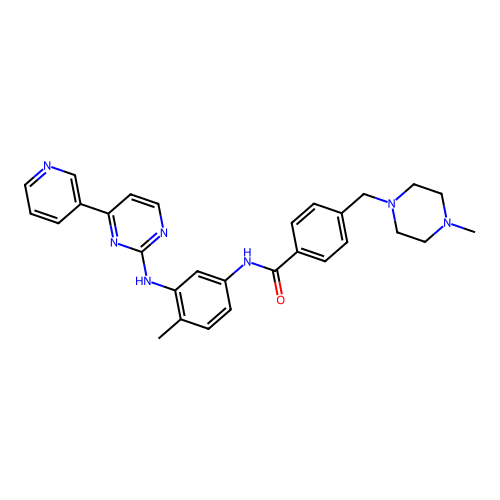

In [2]:
test_smiles = "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"
test_mol = Chem.MolFromSmiles(test_smiles)
Draw.MolsToImage([test_mol], subImgSize=(500,500))

RING FRAGMENTS

Ring 1 (ring):
  Base SMILES:     Cc1ccccc1
  Wildcard SMILES: Cc1ccc([*:1])cc1[*:2]
  RDKit readable:  True
  Size: 6, Heteroatoms: 0
  Attachment atoms: [2, 4]

Ring 2 (ring):
  Base SMILES:     c1ccccc1
  Wildcard SMILES: c1cc([*:4])ccc1[*:3]
  RDKit readable:  True
  Size: 6, Heteroatoms: 0
  Attachment atoms: [10, 13]

Ring 3 (ring):
  Base SMILES:     CN1CCNCC1
  Wildcard SMILES: CN1CCN([*:5])CC1
  RDKit readable:  True
  Size: 6, Heteroatoms: 2
  Attachment atoms: [17]

Ring 4 (ring):
  Base SMILES:     c1cncnc1
  Wildcard SMILES: c1cc([*:6])nc([*:7])n1
  RDKit readable:  True
  Size: 6, Heteroatoms: 2
  Attachment atoms: [25, 29]

Ring 5 (ring):
  Base SMILES:     c1ccncc1
  Wildcard SMILES: c1cncc([*:6])c1
  RDKit readable:  True
  Size: 6, Heteroatoms: 1
  Attachment atoms: [31]

NON-RING FRAGMENTS

Fragment 1 (linker):
  Base SMILES:     NC=O
  Wildcard SMILES: O=C(N[*:1])[*:3]
  RDKit readable:  True
  Size: 3, Heteroatoms: 2
  Attachment atoms: [7, 8]

Frag

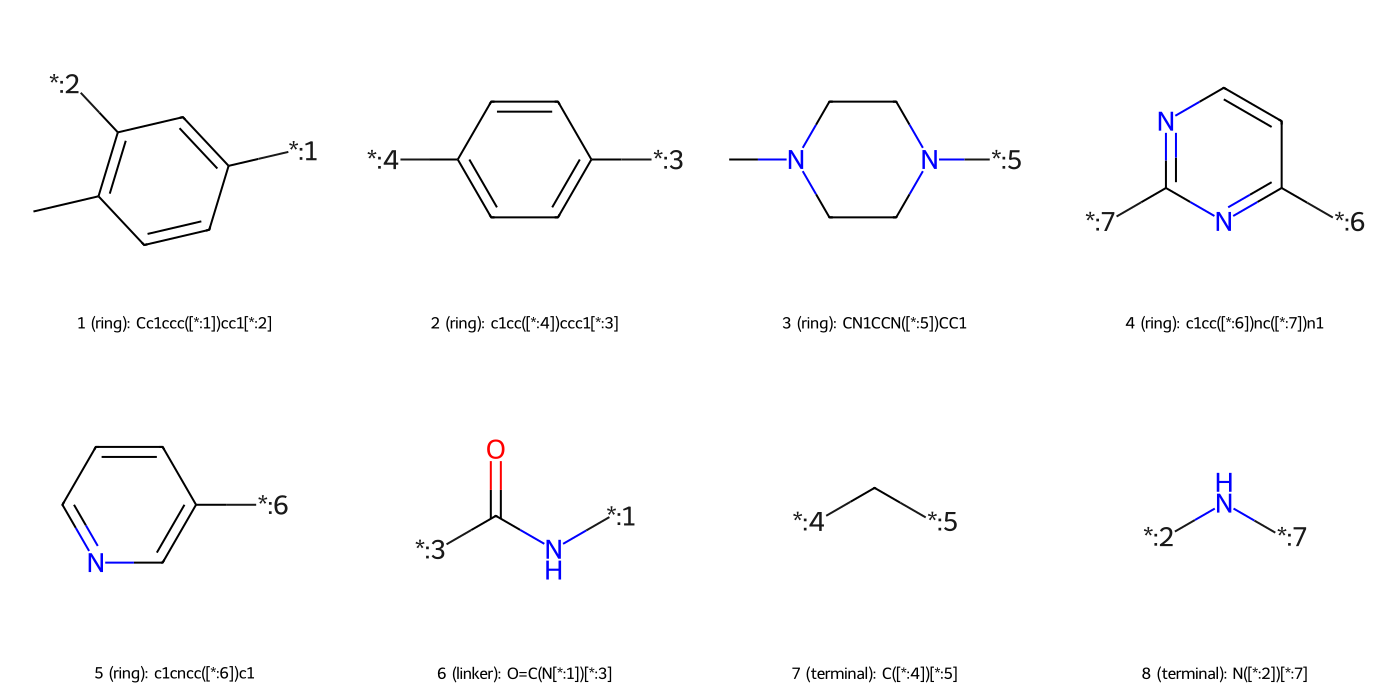


PAIRWISE COMBINATION VISUALIZATION


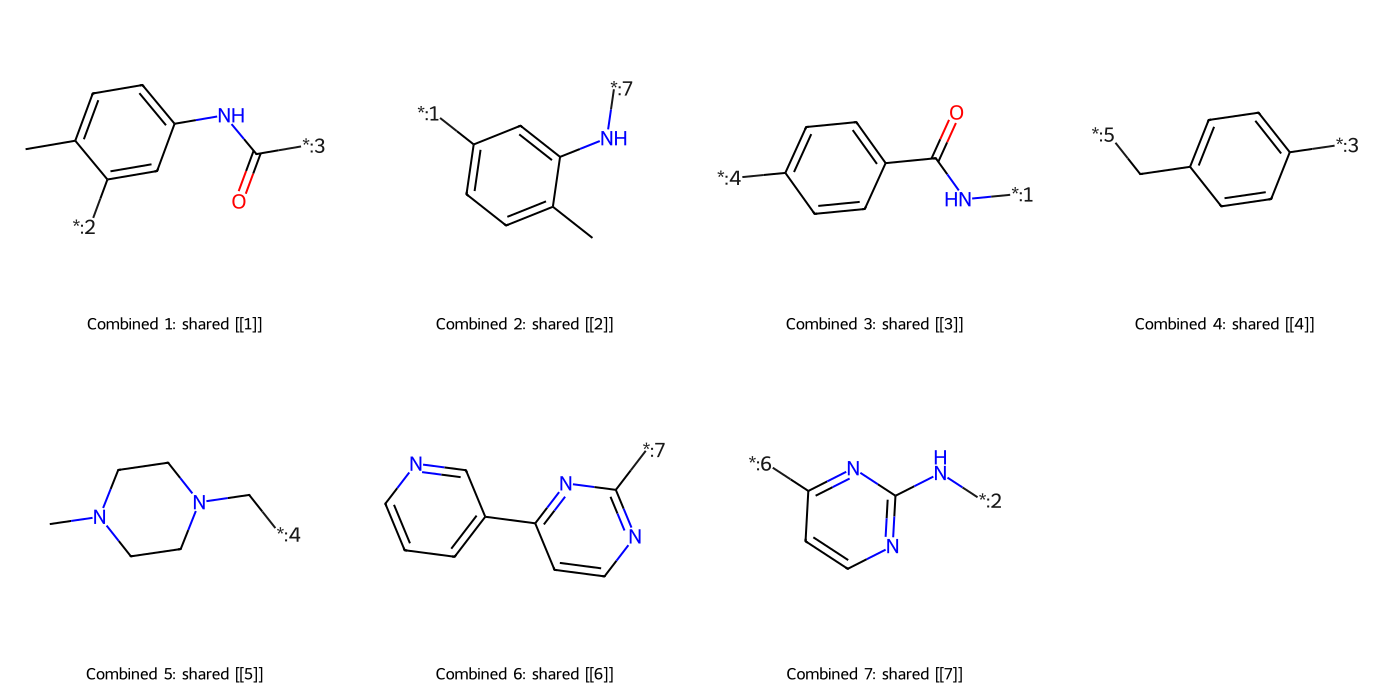

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from typing import List, Dict, Set, Tuple
from IPython.display import display

def decompose_molecule_with_wildcards(mol: Chem.Mol, include_terminal_substituents: bool = True, 
                                       preserve_fused_rings: bool = True) -> Dict[str, List[Dict]]:
    """
    Decompose a molecule into its individual rings (or fused ring systems) AND non-ring fragments,
    adding numbered wildcard dummy atoms ([*:1], [*:2], etc.) at each attachment point.
    
    Also generates pairwise combinations of fragments that share attachment points.
    
    Connected fragments will have matching dummy atom numbers indicating which pieces
    connect to each other.
    
    Terminal substituents (e.g., methyl groups) that are only attached to the ring
    and not to any other functional groups can optionally be included as part of the ring.
    
    Fused/bicyclic ring systems can be preserved as single units.

    Args:
        mol: RDKit Mol object
        include_terminal_substituents: If True, include terminal groups (like -CH3) as part of the ring
        preserve_fused_rings: If True, keep fused/bicyclic rings together as single units

    Returns:
        Dict with three keys:
            - 'rings': List of ring fragment dicts
            - 'non_rings': List of non-ring fragment dicts
            - 'pairwise_combinations': List of combined fragment dicts (fragments joined at shared attachment points)
        
        Each dict contains:
            - 'base_smiles': SMILES of the fragment without wildcards
            - 'wildcard_smiles': SMILES with numbered [*:n] at attachment points (RDKit-readable)
            - 'frag_mol': RDKit Mol of the fragment with wildcards (for depiction)
            - 'atom_indices': tuple of atom indices in parent molecule
            - 'attachment_atoms': list of parent atom indices that are attachment points
            - 'size': number of heavy atoms (excluding wildcards)
            - 'hetero_count': number of heteroatoms
            - 'frag_type': 'ring', 'fused_ring', 'linker', 'terminal', 'combined', etc.
            
        For pairwise_combinations, additional keys:
            - 'source_fragments': list of original fragment wildcard SMILES that were combined
            - 'shared_attachment_nums': list of attachment point numbers that were joined
    """
    if mol is None:
        return {'rings': [], 'non_rings': [], 'pairwise_combinations': []}

    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    
    # Get all atoms that are part of any ring
    all_ring_atoms = set()
    for ring in atom_rings:
        all_ring_atoms.update(ring)
    
    # ============== PART 1: Process Ring Systems ==============
    
    # Group fused rings together if requested
    if preserve_fused_rings and atom_rings:
        ring_sets = [set(ring) for ring in atom_rings]
        
        merged = True
        while merged:
            merged = False
            new_ring_sets = []
            used = [False] * len(ring_sets)
            
            for i in range(len(ring_sets)):
                if used[i]:
                    continue
                current = ring_sets[i].copy()
                used[i] = True
                
                for j in range(i + 1, len(ring_sets)):
                    if used[j]:
                        continue
                    if current & ring_sets[j]:
                        current |= ring_sets[j]
                        used[j] = True
                        merged = True
                
                new_ring_sets.append(current)
            
            ring_sets = new_ring_sets
        
        ring_systems = [tuple(sorted(rs)) for rs in ring_sets]
    else:
        ring_systems = [tuple(ring) for ring in atom_rings] if atom_rings else []
    
    # First pass: collect all fragments and their atoms
    all_fragments = []  # List of (frag_type_category, ring_system_or_none, atom_set, is_fused)
    atoms_assigned_to_rings = set()

    for ring_system in ring_systems:
        ring_atoms = set(ring_system)
        is_fused = preserve_fused_rings and len(ring_system) > 6
        
        # Expand ring atoms to include terminal substituents if requested
        if include_terminal_substituents:
            expanded_atoms = set(ring_atoms)
            atoms_to_check = list(ring_atoms)
            
            while atoms_to_check:
                a_idx = atoms_to_check.pop()
                atom = mol.GetAtomWithIdx(a_idx)
                
                for neighbor in atom.GetNeighbors():
                    nb_idx = neighbor.GetIdx()
                    if nb_idx in expanded_atoms:
                        continue
                    
                    if nb_idx not in all_ring_atoms:
                        nb_atom = mol.GetAtomWithIdx(nb_idx)
                        nb_neighbors = [n.GetIdx() for n in nb_atom.GetNeighbors()]
                        external_neighbors = [n for n in nb_neighbors if n not in expanded_atoms]
                        
                        is_terminal = True
                        for ext_n in external_neighbors:
                            ext_atom = mol.GetAtomWithIdx(ext_n)
                            if ext_n in all_ring_atoms:
                                is_terminal = False
                                break
                            ext_neighbors = [n.GetIdx() for n in ext_atom.GetNeighbors()]
                            if len([n for n in ext_neighbors if n not in expanded_atoms and n != nb_idx]) > 0:
                                is_terminal = False
                                break
                        
                        if is_terminal and len(external_neighbors) == 0:
                            expanded_atoms.add(nb_idx)
                            atoms_to_check.append(nb_idx)
            
            ring_atoms_list = list(expanded_atoms)
        else:
            ring_atoms_list = list(ring_atoms)
        
        atoms_assigned_to_rings.update(ring_atoms_list)
        all_fragments.append(('ring', ring_system, set(ring_atoms_list), is_fused))
    
    # Get non-ring atoms
    all_atoms = set(range(mol.GetNumAtoms()))
    non_ring_atoms = all_atoms - atoms_assigned_to_rings
    
    # Find connected components among non-ring atoms
    if non_ring_atoms:
        visited = set()
        
        for start_atom in non_ring_atoms:
            if start_atom in visited:
                continue
            
            component = set()
            queue = [start_atom]
            
            while queue:
                current = queue.pop(0)
                if current in visited:
                    continue
                if current not in non_ring_atoms:
                    continue
                    
                visited.add(current)
                component.add(current)
                
                atom = mol.GetAtomWithIdx(current)
                for neighbor in atom.GetNeighbors():
                    nb_idx = neighbor.GetIdx()
                    if nb_idx in non_ring_atoms and nb_idx not in visited:
                        queue.append(nb_idx)
            
            if component:
                all_fragments.append(('non_ring', None, component, False))
    
    # ============== Build Bond-to-Number Mapping ==============
    # Find all bonds between different fragments and assign numbers
    
    bond_number_map = {}  # (atom1_idx, atom2_idx) -> number (with atom1 < atom2)
    current_bond_number = 1
    
    for i, (cat1, rs1, atoms1, _) in enumerate(all_fragments):
        for j, (cat2, rs2, atoms2, _) in enumerate(all_fragments):
            if i >= j:
                continue
            
            # Find bonds between fragment i and fragment j
            for a1 in atoms1:
                atom = mol.GetAtomWithIdx(a1)
                for neighbor in atom.GetNeighbors():
                    a2 = neighbor.GetIdx()
                    if a2 in atoms2:
                        bond_key = (min(a1, a2), max(a1, a2))
                        if bond_key not in bond_number_map:
                            bond_number_map[bond_key] = current_bond_number
                            current_bond_number += 1
    
    # ============== Process Each Fragment with Numbered Dummies ==============
    
    def process_fragment(atom_set: Set[int], frag_category: str, ring_system: Tuple = None, 
                        is_fused: bool = False) -> Dict:
        """Process a single fragment and return its info dict with numbered dummy atoms."""
        atom_list = list(atom_set)
        
        # Identify attachment bonds and their numbers
        attachment_info = []  # List of (internal_atom, external_atom, bond_number)
        for a_idx in atom_list:
            atom = mol.GetAtomWithIdx(a_idx)
            for neighbor in atom.GetNeighbors():
                nb_idx = neighbor.GetIdx()
                if nb_idx not in atom_set:
                    bond_key = (min(a_idx, nb_idx), max(a_idx, nb_idx))
                    bond_num = bond_number_map.get(bond_key, 0)
                    attachment_info.append((a_idx, nb_idx, bond_num))
        
        attachment_atoms = sorted(set(a for a, _, _ in attachment_info))
        
        # Determine fragment type for non-rings
        if frag_category == 'non_ring':
            if len(attachment_atoms) == 0:
                frag_type = 'isolated'
            elif len(attachment_atoms) == 1:
                frag_type = 'terminal'
            else:
                frag_type = 'linker'
        else:
            frag_type = 'fused_ring' if is_fused else 'ring'
        
        base_smi = Chem.MolFragmentToSmiles(mol, atom_list, canonical=True)
        
        # Get bonds to break with their dummy labels
        bonds_to_break = []
        dummy_labels = []  # List of (bond_idx, (label_for_begin, label_for_end))
        
        for a_idx, nb_idx, bond_num in attachment_info:
            bond = mol.GetBondBetweenAtoms(a_idx, nb_idx)
            if bond is not None:
                bond_idx = bond.GetIdx()
                if bond_idx not in [b for b, _ in dummy_labels]:
                    # Determine which end is inside our fragment
                    begin_idx = bond.GetBeginAtomIdx()
                    end_idx = bond.GetEndAtomIdx()
                    
                    if begin_idx in atom_set:
                        # Begin is inside, end is outside
                        # The dummy attached to begin gets the label
                        dummy_labels.append((bond_idx, (bond_num, bond_num)))
                    else:
                        # End is inside, begin is outside
                        dummy_labels.append((bond_idx, (bond_num, bond_num)))
                    
                    bonds_to_break.append(bond_idx)
        
        frag_mol = None
        wildcard_smi = None
        
        if bonds_to_break:
            try:
                # Create dummy labels list in bond order
                dummy_label_list = []
                for bond_idx in bonds_to_break:
                    for bi, (l1, l2) in dummy_labels:
                        if bi == bond_idx:
                            dummy_label_list.append((l1, l2))
                            break
                
                frag_mol_temp = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True, 
                                                      dummyLabels=dummy_label_list)
                frags = Chem.GetMolFrags(frag_mol_temp, asMols=True, sanitizeFrags=False)
                frag_atom_lists = Chem.GetMolFrags(frag_mol_temp, asMols=False)
                
                target_frag = None
                for frag, frag_atoms in zip(frags, frag_atom_lists):
                    frag_atoms_set = set(frag_atoms)
                    
                    # Check if this fragment contains atoms from our atom_set
                    check_atoms = ring_system if ring_system else atom_list
                    if any(a_idx in frag_atoms_set for a_idx in check_atoms):
                        non_dummy_count = sum(1 for a in frag.GetAtoms() if a.GetAtomicNum() != 0)
                        if non_dummy_count == len(atom_list):
                            target_frag = frag
                            break
                
                if target_frag is not None:
                    frag_mol = target_frag
                    
                    # Convert isotope labels to atom map numbers for [*:n] format
                    rw = Chem.RWMol(frag_mol)
                    for atom in rw.GetAtoms():
                        if atom.GetAtomicNum() == 0:
                            isotope = atom.GetIsotope()
                            if isotope > 0:
                                atom.SetAtomMapNum(isotope)
                            atom.SetIsotope(0)
                    frag_mol = rw.GetMol()
                    
                    try:
                        Chem.SanitizeMol(frag_mol)
                    except:
                        try:
                            for atom in frag_mol.GetAtoms():
                                atom.SetIsAromatic(False)
                            for bond in frag_mol.GetBonds():
                                bond.SetIsAromatic(False)
                            Chem.SanitizeMol(frag_mol)
                        except:
                            frag_mol = None
            except Exception as e:
                frag_mol = None
        
        if frag_mol is None:
            try:
                frag_mol = Chem.MolFromSmiles(base_smi)
                wildcard_smi = base_smi
            except:
                return None
        
        if frag_mol is None:
            return None

        try:
            rdDepictor.Compute2DCoords(frag_mol)
        except:
            pass

        if wildcard_smi is None:
            try:
                wildcard_smi = Chem.MolToSmiles(frag_mol, canonical=True)
            except:
                wildcard_smi = base_smi
        
        test_mol = Chem.MolFromSmiles(wildcard_smi)
        if test_mol is None:
            wildcard_smi = base_smi

        hetero_count = sum(
            1 for a in frag_mol.GetAtoms()
            if a.GetAtomicNum() not in (0, 1, 6)
        )
        
        result = {
            'base_smiles': base_smi,
            'wildcard_smiles': wildcard_smi,
            'frag_mol': frag_mol,
            'atom_indices': tuple(atom_list),
            'attachment_atoms': attachment_atoms,
            'size': len(ring_system) if ring_system else len(atom_list),
            'hetero_count': hetero_count,
            'frag_type': frag_type
        }
        
        if ring_system:
            result['core_ring_atoms'] = ring_system
            result['total_atoms'] = len(atom_list)
        
        return result
    
    # Process all fragments
    ring_results = []
    non_ring_results = []
    seen_wildcard_smiles = set()
    
    for cat, ring_sys, atoms, is_fused in all_fragments:
        result = process_fragment(atoms, cat, ring_sys, is_fused)
        if result is None:
            continue
        
        if result['wildcard_smiles'] in seen_wildcard_smiles:
            continue
        seen_wildcard_smiles.add(result['wildcard_smiles'])
        
        if cat == 'ring':
            ring_results.append(result)
        else:
            non_ring_results.append(result)

    # Generate pairwise combinations of fragments that share attachment points
    def get_attachment_nums(wildcard_smiles: str) -> Set[int]:
        """Extract attachment point numbers from wildcard SMILES."""
        import re
        matches = re.findall(r'\[\*:(\d+)\]', wildcard_smiles)
        return set(int(m) for m in matches)
    
    def combine_fragments_at_attachment(frag1: Dict, frag2: Dict, shared_num: int) -> Dict:
        """
        Combine two fragments by joining them at a shared attachment point number.
        The dummy atoms with the shared number are removed and replaced with a bond.
        """
        mol1 = Chem.MolFromSmiles(frag1['wildcard_smiles'])
        mol2 = Chem.MolFromSmiles(frag2['wildcard_smiles'])
        
        if mol1 is None or mol2 is None:
            return None
        
        # Find the dummy atom with the shared attachment number in each molecule
        # Check both atom map number ([*:n] format) and isotope
        dummy1_idx = None
        dummy1_neighbor_idx = None
        for atom in mol1.GetAtoms():
            if atom.GetAtomicNum() == 0:  # Dummy atom
                map_num = atom.GetAtomMapNum()
                isotope = atom.GetIsotope()
                if map_num == shared_num or isotope == shared_num:
                    dummy1_idx = atom.GetIdx()
                    neighbors = atom.GetNeighbors()
                    if neighbors:
                        dummy1_neighbor_idx = neighbors[0].GetIdx()
                    break
        
        dummy2_idx = None
        dummy2_neighbor_idx = None
        for atom in mol2.GetAtoms():
            if atom.GetAtomicNum() == 0:  # Dummy atom
                map_num = atom.GetAtomMapNum()
                isotope = atom.GetIsotope()
                if map_num == shared_num or isotope == shared_num:
                    dummy2_idx = atom.GetIdx()
                    neighbors = atom.GetNeighbors()
                    if neighbors:
                        dummy2_neighbor_idx = neighbors[0].GetIdx()
                    break
        
        if dummy1_idx is None or dummy2_idx is None:
            return None
        if dummy1_neighbor_idx is None or dummy2_neighbor_idx is None:
            return None
        
        # Combine the molecules
        combined = Chem.CombineMols(mol1, mol2)
        rw_mol = Chem.RWMol(combined)
        
        # Adjust indices for mol2 atoms (they shift by mol1 atom count)
        mol1_atom_count = mol1.GetNumAtoms()
        dummy2_idx_combined = dummy2_idx + mol1_atom_count
        dummy2_neighbor_idx_combined = dummy2_neighbor_idx + mol1_atom_count
        
        # Add bond between the neighbors of the dummy atoms
        rw_mol.AddBond(dummy1_neighbor_idx, dummy2_neighbor_idx_combined, Chem.BondType.SINGLE)
        
        # Remove dummy atoms (remove higher index first to avoid index shifting)
        indices_to_remove = sorted([dummy1_idx, dummy2_idx_combined], reverse=True)
        for idx in indices_to_remove:
            rw_mol.RemoveAtom(idx)
        
        try:
            Chem.SanitizeMol(rw_mol)
            combined_mol = rw_mol.GetMol()
        except:
            return None
        
        combined_smiles = Chem.MolToSmiles(combined_mol)
        
        # Count remaining attachment points and heteroatoms
        remaining_attachments = get_attachment_nums(combined_smiles)
        hetero_count = sum(1 for a in combined_mol.GetAtoms() if a.GetAtomicNum() not in (0, 1, 6))
        size = sum(1 for a in combined_mol.GetAtoms() if a.GetAtomicNum() != 0)
        
        return {
            'base_smiles': combined_smiles,  # Same as wildcard for combined
            'wildcard_smiles': combined_smiles,
            'frag_mol': combined_mol,
            'atom_indices': tuple(set(frag1['atom_indices']) | set(frag2['atom_indices'])),
            'attachment_atoms': list(set(frag1['attachment_atoms']) | set(frag2['attachment_atoms'])),
            'size': size,
            'hetero_count': hetero_count,
            'frag_type': 'combined',
            'source_fragments': [frag1['wildcard_smiles'], frag2['wildcard_smiles']],
            'shared_attachment_nums': [shared_num]
        }
    
    # Find all pairs of fragments that share attachment points
    pairwise_results = []
    all_fragments_list = ring_results + non_ring_results
    seen_pairs = set()
    seen_combined_smiles = set()
    
    for i, frag1 in enumerate(all_fragments_list):
        nums1 = get_attachment_nums(frag1['wildcard_smiles'])
        for j, frag2 in enumerate(all_fragments_list):
            if i >= j:  # Skip self and already-checked pairs
                continue
            nums2 = get_attachment_nums(frag2['wildcard_smiles'])
            shared_nums = nums1 & nums2  # Intersection of attachment point numbers
            
            if shared_nums:
                # Create a canonical key for this pair to avoid duplicates
                pair_key = tuple(sorted([frag1['wildcard_smiles'], frag2['wildcard_smiles']]))
                if pair_key in seen_pairs:
                    continue
                seen_pairs.add(pair_key)
                
                # Combine at each shared attachment point (usually just one)
                for shared_num in shared_nums:
                    combined = combine_fragments_at_attachment(frag1, frag2, shared_num)
                    if combined is not None:
                        if combined['wildcard_smiles'] not in seen_combined_smiles:
                            seen_combined_smiles.add(combined['wildcard_smiles'])
                            pairwise_results.append(combined)

    return {'rings': ring_results, 'non_rings': non_ring_results, 'pairwise_combinations': pairwise_results}

# Keep the old function name as an alias for backward compatibility
def decompose_rings_with_wildcards(mol: Chem.Mol, include_terminal_substituents: bool = True, 
                                    preserve_fused_rings: bool = True) -> List[Dict]:
    """Backward compatible wrapper - returns only rings."""
    result = decompose_molecule_with_wildcards(mol, include_terminal_substituents, preserve_fused_rings)
    return result['rings']

# Example usage with the query molecule
decomposition = decompose_molecule_with_wildcards(test_mol, include_terminal_substituents=True, preserve_fused_rings=True)

print("=" * 60)
print("RING FRAGMENTS")
print("=" * 60)
for i, frag in enumerate(decomposition['rings'], start=1):
    print(f"\nRing {i} ({frag['frag_type']}):")
    print(f"  Base SMILES:     {frag['base_smiles']}")
    print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
    test = Chem.MolFromSmiles(frag['wildcard_smiles'])
    print(f"  RDKit readable:  {test is not None}")
    print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
    print(f"  Attachment atoms: {frag['attachment_atoms']}")

print("\n" + "=" * 60)
print("NON-RING FRAGMENTS")
print("=" * 60)
for i, frag in enumerate(decomposition['non_rings'], start=1):
    print(f"\nFragment {i} ({frag['frag_type']}):")
    print(f"  Base SMILES:     {frag['base_smiles']}")
    print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
    test = Chem.MolFromSmiles(frag['wildcard_smiles'])
    print(f"  RDKit readable:  {test is not None}")
    print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
    print(f"  Attachment atoms: {frag['attachment_atoms']}")

print("\n" + "=" * 60)
print("PAIRWISE COMBINATIONS")
print("=" * 60)
for i, frag in enumerate(decomposition['pairwise_combinations'], start=1):
    print(f"\nCombined {i} ({frag['frag_type']}):")
    print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
    test = Chem.MolFromSmiles(frag['wildcard_smiles'])
    print(f"  RDKit readable:  {test is not None}")
    print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
    print(f"  Source fragments: {frag['source_fragments']}")
    print(f"  Shared attachment point(s): {frag['shared_attachment_nums']}")

# Visualize all fragments
print("\n" + "=" * 60)
print("VISUALIZATION")
print("=" * 60)

all_frags = decomposition['rings'] + decomposition['non_rings']
if all_frags:
    mols = [f['frag_mol'] for f in all_frags]
    legends = []
    for i, f in enumerate(all_frags):
        ftype = f['frag_type']
        legends.append(f"{i+1} ({ftype}): {f['wildcard_smiles']}")
    
    grid = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(350, 350))
    display(grid)

# Visualize pairwise combinations separately
if decomposition['pairwise_combinations']:
    print("\n" + "=" * 60)
    print("PAIRWISE COMBINATION VISUALIZATION")
    print("=" * 60)
    mols = [f['frag_mol'] for f in decomposition['pairwise_combinations']]
    legends = []
    for i, f in enumerate(decomposition['pairwise_combinations']):
        legends.append(f"Combined {i+1}: shared [{f['shared_attachment_nums']}]")
    
    grid = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(350, 350))
    display(grid)

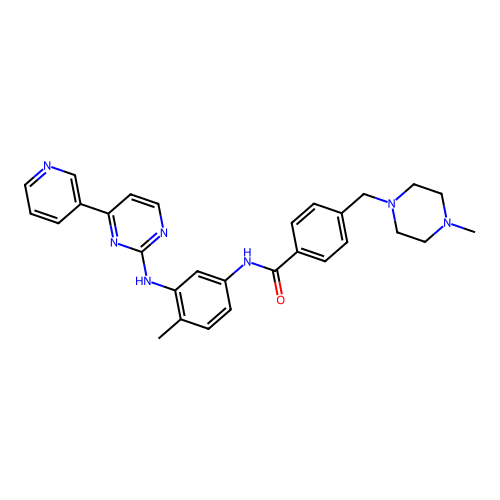

In [4]:
Draw.MolsToImage([test_mol], subImgSize=(500,500))

## Simplified function

That returns all fundamental and pairwise fragments

In [5]:
def get_all_fragments(smiles: str, include_terminal_substituents: bool = True, 
                      preserve_fused_rings: bool = True) -> List[str]:
    """
    Simplified function that accepts a SMILES string and returns all wildcard SMILES
    of fundamental fragments (rings and non-rings) and their pairwise combinations.
    
    Args:
        smiles: Input SMILES string
        include_terminal_substituents: If True, include terminal groups as part of rings
        preserve_fused_rings: If True, keep fused/bicyclic rings together
    
    Returns:
        List of wildcard SMILES strings for all fragments (fundamental + pairwise)
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    
    decomposition = decompose_molecule_with_wildcards(
        mol, 
        include_terminal_substituents=include_terminal_substituents,
        preserve_fused_rings=preserve_fused_rings
    )
    
    # Collect all wildcard SMILES
    all_smiles = []
    
    # Add fundamental fragments (rings and non-rings)
    for frag in decomposition['rings']:
        all_smiles.append(frag['wildcard_smiles'])
    
    for frag in decomposition['non_rings']:
        all_smiles.append(frag['wildcard_smiles'])
    
    # Add pairwise combinations
    for frag in decomposition['pairwise_combinations']:
        all_smiles.append(frag['wildcard_smiles'])
    
    return all_smiles


# Example usage
fragments = get_all_fragments(test_smiles)

print(f"Total fragments: {len(fragments)}")
print("\nAll fragment SMILES:")
for i, smi in enumerate(fragments, 1): #enumerate the list and start with number 1
    print(f"  {i}. {smi}")

Total fragments: 15

All fragment SMILES:
  1. Cc1ccc([*:1])cc1[*:2]
  2. c1cc([*:4])ccc1[*:3]
  3. CN1CCN([*:5])CC1
  4. c1cc([*:6])nc([*:7])n1
  5. c1cncc([*:6])c1
  6. O=C(N[*:1])[*:3]
  7. C([*:4])[*:5]
  8. N([*:2])[*:7]
  9. Cc1ccc(NC(=O)[*:3])cc1[*:2]
  10. Cc1ccc([*:1])cc1N[*:7]
  11. O=C(N[*:1])c1ccc([*:4])cc1
  12. c1cc([*:3])ccc1C[*:5]
  13. CN1CCN(C[*:4])CC1
  14. c1cncc(-c2ccnc([*:7])n2)c1
  15. c1cc([*:6])nc(N[*:2])n1


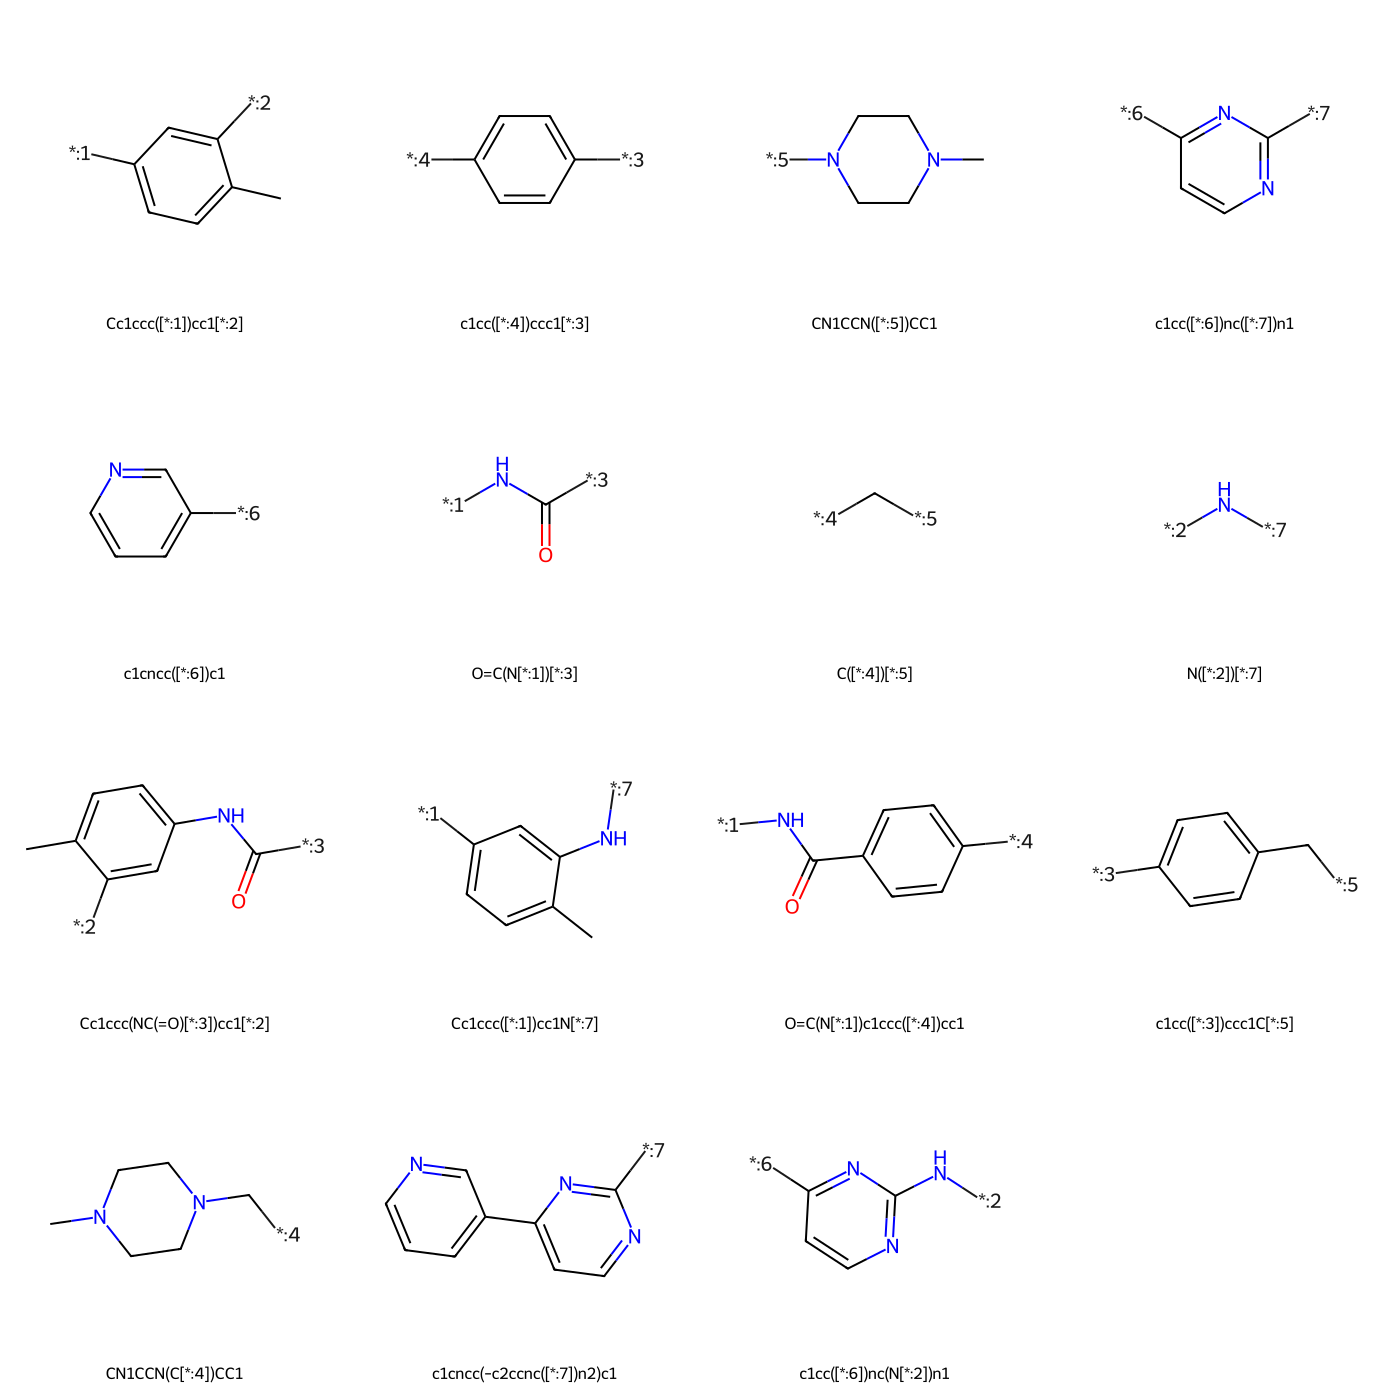

In [6]:
# Convert SMILES to Mol objects for visualization
fragment_mols = [Chem.MolFromSmiles(smi) for smi in fragments]
Draw.MolsToGridImage(fragment_mols, legends=fragments, molsPerRow=4, subImgSize=(350, 350))